# importy

In [71]:
import skimage as ski
from skimage import color, filters
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
from PIL import Image
from scipy import ndimage as ndi
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import gmean
from typing import Literal
import copy
from scipy import stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from skimage import filters
from sklearn.metrics import accuracy_score
import joblib
from random import sample
import time

# Filtration
---
## Load images

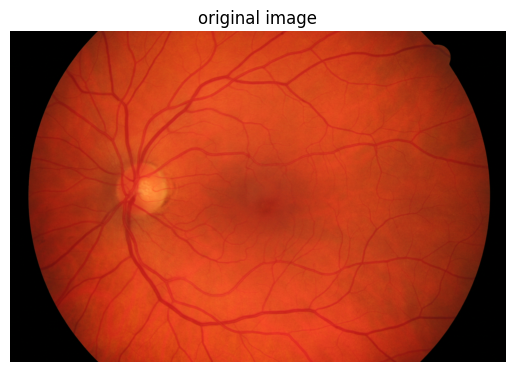

In [72]:
img = 'img/06_h.jpg'

def read_img(filename):
    image = ski.io.imread(filename).astype(np.float64)
    return image / np.max(image)# Normalizujemy wartości pikseli obrazu do zakresu [0, 1]

original_img = read_img(img)
plt.figure()
plt.imshow(original_img)
plt.axis('off')
plt.title('original image')
plt.show()

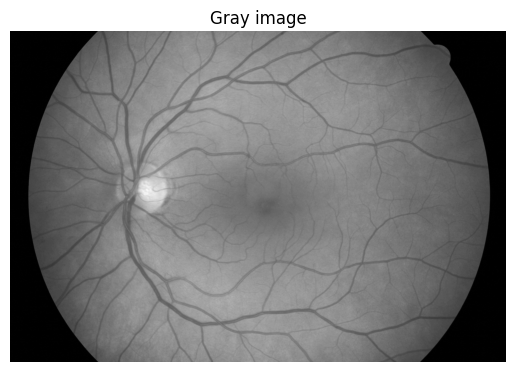

In [73]:
def read_tif(tif_img):
    img = Image.open(tif_img)
    return np.array(img)

plt.figure()
plt.imshow(color.rgb2gray(original_img), cmap='gray')
plt.axis('off')
plt.title('Gray image')
plt.show()

## Wykrywanie naczyń krwionośnych

RU:
Создается бинарная маска, где пиксели изображения eye, значения которых выше порога x, помечаются как True, а остальные - как False.
Таким образом, маска выделяет области изображения, которые, вероятно, являются сосудами, так как они имеют более высокую интенсивность по сравнению с остальной частью изображения.

Фоновые области: Самые темные области изображения, такие как пространство вокруг глаза и области без сосудов.
Промежуточные области: Области средней интенсивности, которые могут представлять более темные части сосудов или структуры с меньшей интенсивностью.
Самые яркие области: Области с наибольшей интенсивностью, которые, скорее всего, являются кровеносными сосудами.

Фильтр Sato используется для выделения трубчатых структур, таких как кровеносные сосуды. Параметр sigmas определяет диапазон масштабов, на которых фильтр будет искать трубчатые структуры

PL:
Tworzona jest maska binarna, w której piksele na obrazie eye, których wartości przekraczają próg x, są oznaczone jako True, a reszta jako False. W ten sposób maska podkreśla obszary obrazu, które prawdopodobnie są naczyniami, ponieważ mają większą intensywność w porównaniu z resztą obrazu.

Obszary tła: najciemniejsze obszary obrazu, takie jak okolice oczu i obszary bez naczyń krwionośnych. 
Obszary pośrednie: obszary o średniej intensywności, które mogą reprezentować ciemniejsze części naczyń lub struktury o mniejszej intensywności. 
Najjaśniejsze obszary: obszary o największej intensywności, którymi najprawdopodobniej są naczynia krwionośne.

Filtr Sato służy do podkreślania struktur rurowych, takich jak naczynia krwionośne. Parametr sigma określa zakres skal, w jakich filtr będzie wyszukiwał struktury rurowe

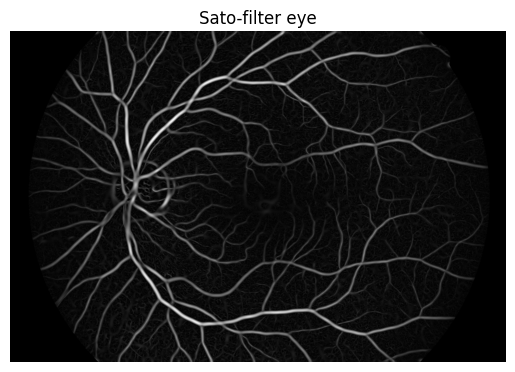

In [74]:
def find_naczynia(img: np.ndarray) -> np.ndarray:
    eye = color.rgb2gray(img) # Преобразуем изображение сетчатки в оттенки серого
    x, y = filters.threshold_multiotsu(eye, classes=3)
    mask = (eye > x) #maska, żeby wyodrębnić
    vessels = filters.sato(eye, sigmas=range(1, 15)) * mask
    return vessels


filtered = find_naczynia(original_img)

plt.figure()
plt.imshow(filtered, cmap='gray')
plt.axis('off')
plt.title('Sato-filter eye')
plt.show()

## Metoda progowania dla zwiększenia jakości obrazu

RU: Применяем пороговое значение гистерезиса для удаления шума и небольших артефактов
0.01 нидний порог 0.03 верхний

PL: Stosujemy próg histerezy, aby usunąć szum i małe artefakty 0,01 dolny próg 0,03 wysoki

In [75]:
def hysteresis_threshold(img: np.ndarray) -> np.ndarray:
    filtered = filters.apply_hysteresis_threshold(img, 0.01, 0.03)
    return filtered

## Przeskalowuje intensywność pikseli obrazu, aby wartości znajdowały się w określonym zakresie. (zwiększamy kontrast pikseli)

RU: Масштабирует интенсивность пикселей изображения для улучшения контрастности.

PL: Skaluje intensywność pikseli obrazu w celu poprawy kontrastu.

In [76]:
def intense_filtered(img: np.ndarray) -> np.ndarray:
    img = ski.exposure.rescale_intensity(img, in_range=(0.009, 0.015))
    return img

## oblicza różne wskaźniki w celu oceny dokładności identyfikacji naczyń na obrazie w porównaniu z maską referencyjną
 
RU: вычисляет различные метрики для оценки точности выделения сосудов на изображении по сравнению с эталонной маской

Преобразование изображений сосудов и маски в бинарные изображения, используя пороговое значение threshold. Пиксели с интенсивностью выше порога считаются частью сосуда.

PL: Obliczamy różne wskaźniki w celu oceny dokładności identyfikacji naczyń na obrazie w porównaniu z maską referencyjną

Konwertujemy obrazy naczyń i masek na obrazy binarne przy użyciu wartości progowej. Piksele o intensywności powyżej progu są uważane za część naczynia.

In [77]:
def check_metrics(naczynia, mask, threshold=0.1):
    predictions = naczynia > threshold
    groundtruth = mask > threshold

    # Obliczamy prawdziwie dodatnie (tp), fałszywie dodatnie (fp), fałszywie ujemne (fn) i prawdziwie ujemne (tn)
    # za pomocą operacji logicznych i funkcji np.sum:
    true_positive = np.sum(predictions & groundtruth)  # Liczba pikseli poprawnie sklasyfikowanych jako naczynia
    false_positive = np.sum(predictions & ~groundtruth) # Liczba pikseli błędnie sklasyfikowanych jako naczynia
    false_negative = np.sum(~predictions & groundtruth) # Liczba pikseli błędnie sklasyfikowana jako tło
    true_negative = np.sum(~predictions & ~groundtruth) # Liczba pikseli poprawnie sklasyfikowanych jako tło

    metrics = {}
    metrics['accuracy'] = (true_positive + true_negative) / (true_negative + false_negative + true_positive + false_positive) # Proporcja poprawnie sklasyfikowanych pikseli.
    metrics['recall'] = true_positive / (true_positive + false_negative) # Proporcja prawidłowo zidentyfikowanych naczyń spośród wszystkich naczyń w masce.
    metrics['specificity'] = true_negative / (false_positive + true_negative) # Proporcja poprawnie zidentyfikowanych pikseli tła ze wszystkich pikseli tła.
    metrics['precision'] = true_positive / (true_positive + false_positive)# Proporcja prawidłowo zidentyfikowanych naczyń spośród wszystkich pikseli zidentyfikowanych jako naczynia.
    metrics['g_mean'] = np.sqrt(metrics['recall'] * metrics['specificity'])# Średnia geometryczna czułości i swoistości, równoważenie ich.
    metrics['confusion_matrix'] = np.array([true_positive, false_positive, false_negative, true_negative]) # Matryca zamieszania pokazująca liczbę prawdziwie pozytywnych, fałszywie pozytywnych, fałszywie negatywnych i prawdziwie negatywnych klasyfikacji.
    
    return metrics

## Ocenianie wskazników ze zdjęc




Zdjecie №1


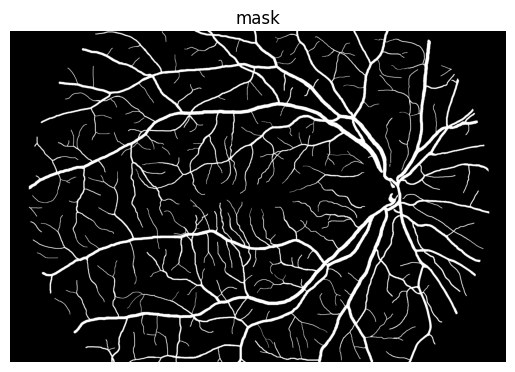

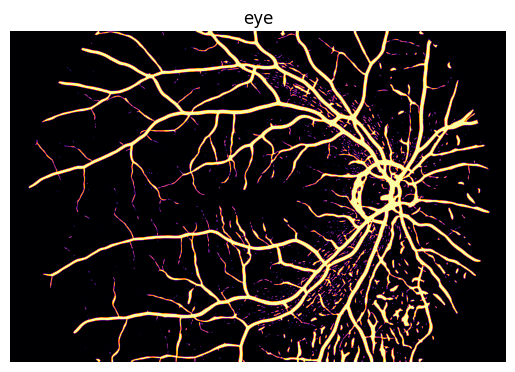

Accuracy score:		 0.93
recall score:		 0.80
Specificity score:	 0.94
Precision score:	 0.62
G-mean: 			 0.87
Confusion matrix: 	 [ 671250  419996  162638 6931460]



Zdjecie №2


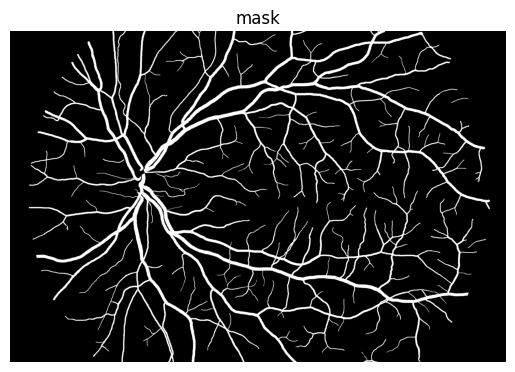

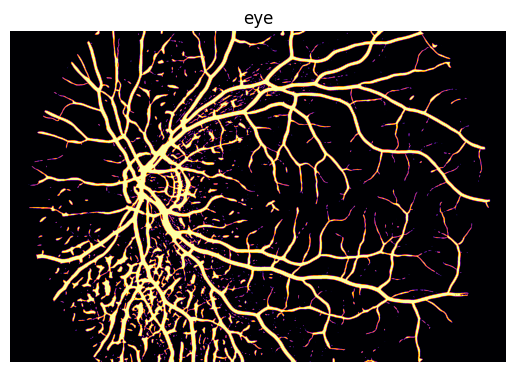

Accuracy score:		 0.92
recall score:		 0.88
Specificity score:	 0.92
Precision score:	 0.55
G-mean: 			 0.90
Confusion matrix: 	 [ 714339  586077   94099 6790829]



Zdjecie №3


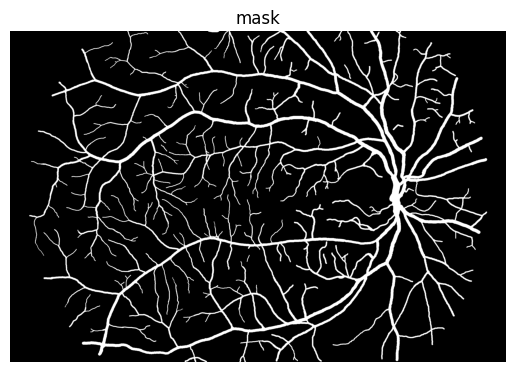

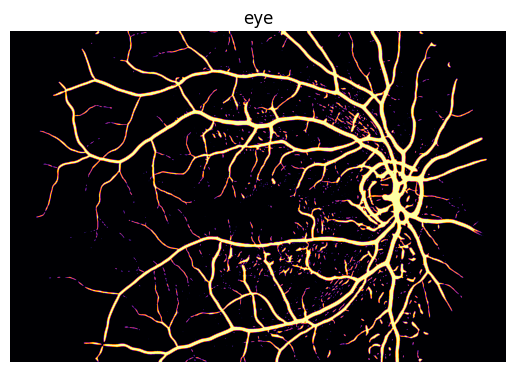

Accuracy score:		 0.94
recall score:		 0.73
Specificity score:	 0.96
Precision score:	 0.68
G-mean: 			 0.84
Confusion matrix: 	 [ 629701  294668  234470 7026505]



Zdjecie №4


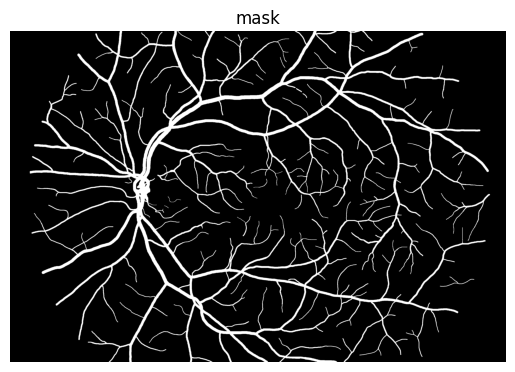

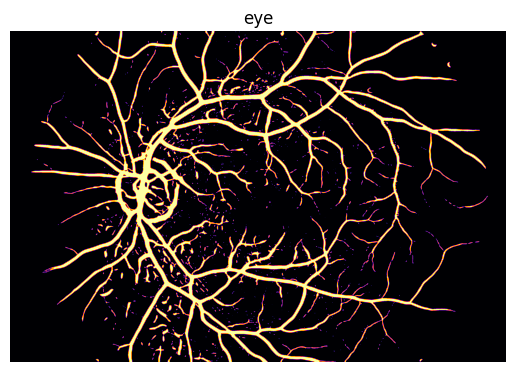

Accuracy score:		 0.94
recall score:		 0.82
Specificity score:	 0.95
Precision score:	 0.65
G-mean: 			 0.88
Confusion matrix: 	 [ 628906  334699  142695 7079044]



Zdjecie №5


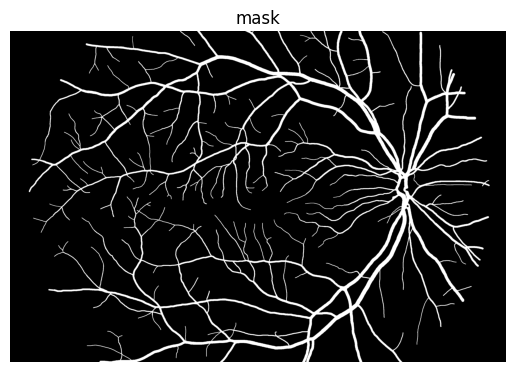

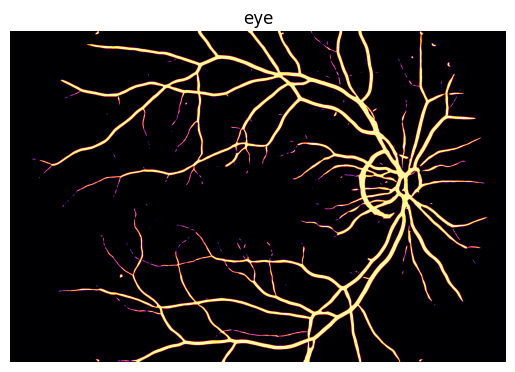

Accuracy score:		 0.96
recall score:		 0.73
Specificity score:	 0.98
Precision score:	 0.78
G-mean: 			 0.85
Confusion matrix: 	 [ 540425  150177  198361 7296381]



Zdjecie №6


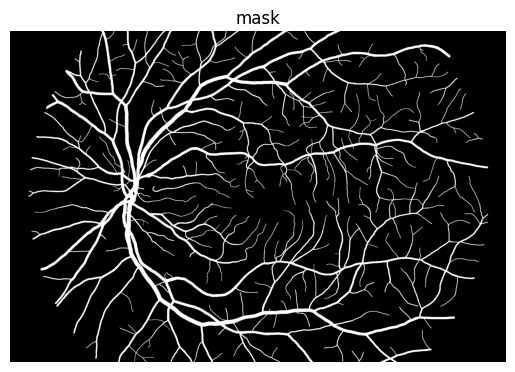

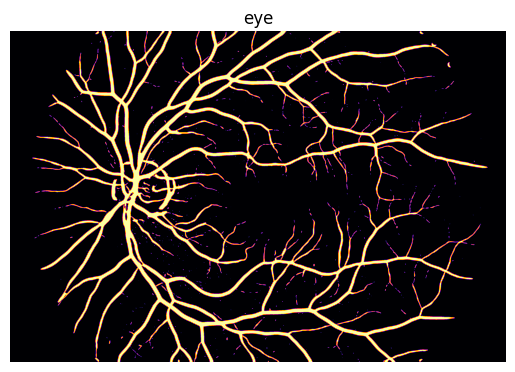

Accuracy score:		 0.95
recall score:		 0.81
Specificity score:	 0.97
Precision score:	 0.73
G-mean: 			 0.89
Confusion matrix: 	 [ 674690  248894  155180 7106580]



Zdjecie №7


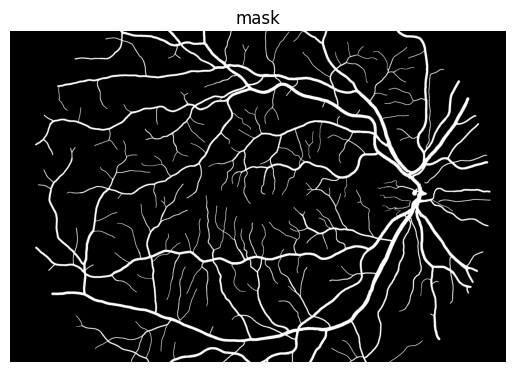

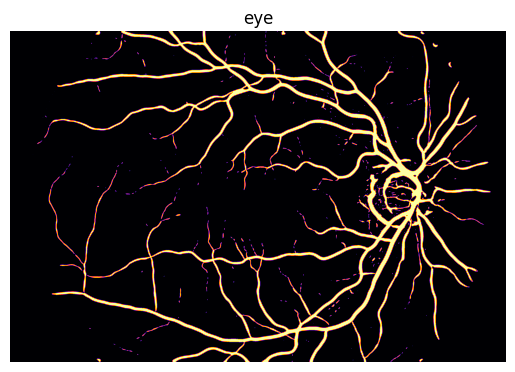

Accuracy score:		 0.96
recall score:		 0.74
Specificity score:	 0.98
Precision score:	 0.77
G-mean: 			 0.85
Confusion matrix: 	 [ 536730  156274  192283 7300057]



Zdjecie №8


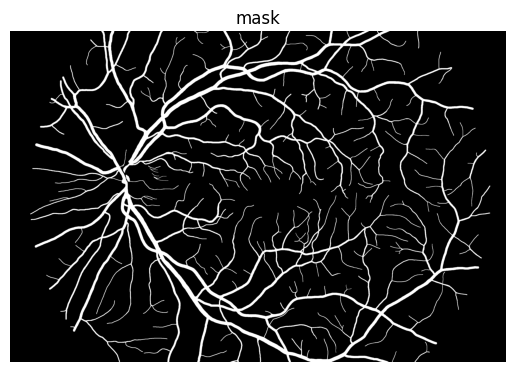

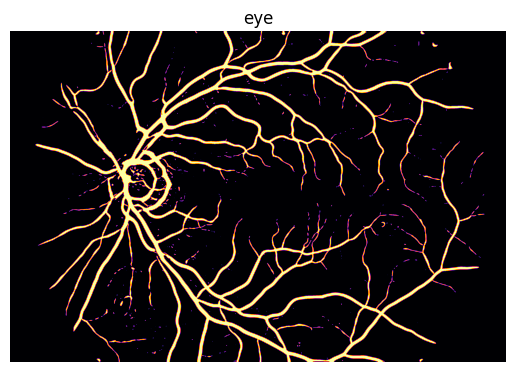

Accuracy score:		 0.96
recall score:		 0.77
Specificity score:	 0.98
Precision score:	 0.79
G-mean: 			 0.87
Confusion matrix: 	 [ 630259  165878  191368 7197839]



Zdjecie №9


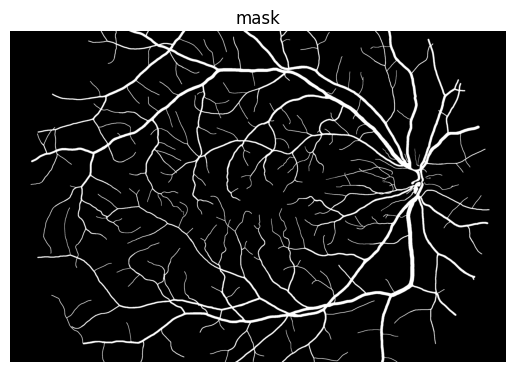

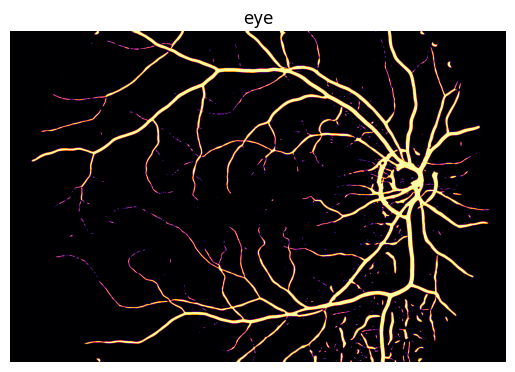

Accuracy score:		 0.96
recall score:		 0.72
Specificity score:	 0.98
Precision score:	 0.71
G-mean: 			 0.84
Confusion matrix: 	 [ 455648  185105  180820 7363771]


In [78]:
for i in range(1, 10):
    eye_img = f'img/0{i}_h.jpg'
    tif_img = f'img/0{i}_h.tif'
    
    eye_image = read_img(eye_img)
    tif_image = read_tif(tif_img)

    print(f'\n\n\nZdjecie №{i}')
    
    plt.figure()
    plt.imshow(tif_image, cmap='gray')
    plt.title('mask')
    plt.axis('off')
    plt.show()
    
    # Wykrywamy naczynia krwionośne na obrazie
    # Poprawa kontrastu obrazu
    # Stosujemy wartość progową
    filtered = hysteresis_threshold(intense_filtered(find_naczynia(eye_image)))
    
    plt.figure()
    plt.imshow(filtered, cmap='inferno')
    plt.title('eye')
    plt.axis('off')
    plt.show()
    
    metric = check_metrics(filtered, tif_image) # Obliczamy metryki oceny
    print(f"Accuracy score:\t\t {metric['accuracy']:.2f}")
    print(f"recall score:\t\t {metric['recall']:.2f}")
    print(f"Specificity score:\t {metric['specificity']:.2f}")
    print(f"Precision score:\t {metric['precision']:.2f}")
    print(f"G-mean: \t\t\t {metric['g_mean']:.2f}")
    print(f"Confusion matrix: \t {metric['confusion_matrix']}")

----------------------------------------------------------------------------------------------------------
# 4.0

## Dzielinie obraza na fragmenty o określonym rozmiarze i zwraca listę tych fragmentów

RU: предназначена для извлечения фрагментов (пятен) из изображения. Каждый фрагмент представляет собой небольшой участок изображения фиксированного размера

PL: Przeznaczony jest do wyodrębniania fragmentów (plam) z obrazu. Każdy fragment to niewielki obszar obrazu o ustalonym rozmiarze

In [79]:
def make_fragments(img):
    height, width = img.shape[:2]
    fragments = []
    for i in range(0, height - 5 + 1, 5):
        for j in range(0, width - 5 + 1, 5):
            fragment = img[i:i + 5, j:j + 5].copy()# Wyodrębniamy fragment obrazu
            fragments.append(fragment)
    return fragments

## Wyodrębnia środkowy piksel z każdego fragmentu obrazu, proguje jego wartość i zwraca listę przetworzonych pikseli

RU: извлекает средние пиксели (по центру) из каждого фрагмента изображения и бинаризует их на основе порогового значения

PL: wyodrębnia średnie piksele (wyśrodkowane) z każdego fragmentu obrazu i binaryzuje je w oparciu o wartość progową

In [80]:
def get_pixels(img):
    height, width = img.shape[:2]
    bias = 5 // 2
    pixels = []
    for i in range(bias, height - bias, 5):
        for j in range(bias, width - bias, 5):
            pixel = int(img[i, j]) # Извлекаем значение центрального пикселя фрагмента
            pixels.append(0 if pixel < 128 else 255) # Пороговое значение для бинаризации
            
    return pixels

## Ekstrahuje cechy obrazu z podanego spłaszczonego fragmentu obrazu. Oblicza momenty (średnia i wariancja) wartości pikseli oraz histogram wartości pikseli.

RU: извлекает признаки из одномерного массива пикселей

PL: wyodrębnia cechy z jednowymiarowej tablicy pikseli

In [1]:
def get_evidence(flat_patch):
    evidence = []
    moments = [np.mean(flat_patch), np.var(flat_patch)] # Obliczamy średnią i wariancję
    histogram = np.histogram(flat_patch, bins=10)[0] # Konstrujemy histogram z 10 przedziałami
    evidence.extend(moments)
    evidence.extend(histogram)

    return evidence

## Proces uczenia modelu regresji logistycznej na zbiorze obrazów

### jest to model zespołowy oparty na drzewach decyzyjnych używany do klasyfikacji.

PL:

ładowanie i wstępne przetwarzanie obrazów, wyodrębnianie funkcji z obrazów, tworzenie i trenowanie modelu uczenia maszynowego oraz zapisywanie wytrenowanego modelu i skalera.

Pętla przechodzi przez obrazy ponumerowane od 1 do 5. Dla każdego obrazu ładowane są trzy pliki: sam obraz, maska i maska dodatkowa.

Rozmiar obrazów i masek jest zmieniany do stałego rozmiaru 1800x1200 pikseli.

Zielony kanał (drugi kanał na obrazie RGB) jest wyodrębniany z obrazu i stosowany do niego histogram w celu poprawy kontrastu.

make_fragments(contrasted_image) i get_pixels(expected_result) to prawdopodobnie funkcje służące odpowiednio do dzielenia obrazu na fragmenty i wydobywania wartości pikseli z maski.

Każdy fragment jest konwertowany na jednowymiarową tablicę, z której pobierane są cechy za pomocą funkcji get_evidence(flat_patch). Wynikowe cechy są dodawane do listy image_set.

Wartości danych i pikseli maski są dodawane do ogólnego zbioru danych.

Wartości danych i maski dzielone są w proporcji 50/50 na zbiory uczące i testowe za pomocą funkcji train_test_split.

Cechy są normalizowane przy użyciu narzędzia StandardScaler. Dane szkoleniowe służą do dopasowania i transformacji skalera, podczas gdy dane testowe są jedynie przekształcane.

Tworzony jest losowy model lasu zawierający 100 drzew, który jest trenowany na podstawie danych szkoleniowych. Model służy do przewidywania danych testowych.

Dokładność modelu oceniana jest na podstawie danych testowych i wyświetlana na ekranie.

Wyszkolony model i moduł skalujący są zapisywane w plikach przy użyciu biblioteki joblib do późniejszego wykorzystania.

RU:

загрузка и предобработка изображений, извлечение признаков из изображений, создание и обучение модели машинного обучения, и сохранение обученной модели и скейлера. 

Цикл проходит по изображениям с номерами от 1 до 5. Для каждого изображения загружаются три файла: само изображение, маска и дополнительная маска.

Изображения и маски изменяются до фиксированного размера 1800x1200 пикселей.

Из изображения извлекается зеленый канал (второй канал в изображении RGB) и на него применяется гистограмма для улучшения контрастности.

make_fragments(contrasted_image) и get_pixels(expected_result) - предположительно, функции для разбиения изображения на фрагменты и извлечения значений пикселей из маски соответственно.

Каждый фрагмент преобразуется в одномерный массив, из которого извлекаются признаки с помощью функции get_evidence(flat_patch). Полученные признаки добавляются в список image_set.

Данные и значения пикселей маски добавляются в общий датасет.

Данные и значения масок разделяются на тренировочные и тестовые наборы в соотношении 50/50 с помощью функции train_test_split.

Признаки нормализуются с использованием StandardScaler. Тренировочные данные используются для подгонки и преобразования скейлера, а тестовые данные только преобразуются.

Создается и обучается модель случайного леса с 100 деревьями на тренировочных данных. Модель используется для предсказания на тестовых данных.

Оценивается точность модели на тестовых данных и выводится на экран.

Обученная модель и скейлер сохраняются в файлы с помощью joblib для последующего использования.

In [82]:
dataset = []
pixels = [] # pusta lista do przechowywania pikseli masek

for i in range(1, 10):
    imgset = []
    image = cv2.imread(f'img/0{i}_h.jpg')
    mask = cv2.imread(f'img/0{i}_h_mask.tif')
    expected_mask = cv2.imread(f'img/0{i}_h.tif')

    #wpisanie rozmiarów
    resized_img = cv2.resize(copy.deepcopy(image), (1800, 1200))
    resized_mask = cv2.resize(mask, (1800, 1200))
    resized_mask_2 = cv2.resize(expected_mask, (1800, 1200))
    
    #podział na kanały zielone
    green_img = resized_img[:, :, 1]
    expected__mask = resized_mask_2[:, :, 1]
    contrasted_image = cv2.equalizeHist(green_img) #równowaga tonalna

    fragments = make_fragments(contrasted_image)
    res_pixels = get_pixels(expected__mask)

    #wyodrębniane cech z obrazków i zapisanie tych cech
    for fragment in fragments: 
        flatten_array = fragment.flatten().astype(float) # konwertujemy fragment obrazu na płaską tablicę i zmień typ danych na float
        evidence = get_evidence(flatten_array)
        imgset.append(list(flatten_array) + evidence)

    dataset.extend(imgset)
    pixels.extend(res_pixels)

#podział na grupy dla treningu i uczenia
x_train, x_test, y_train, y_test = train_test_split(dataset, pixels, test_size=0.5)
#tr - trening, t - test

#skalowanie cech do uczenia i treningu
scaler = StandardScaler()
x_train_transformed = scaler.fit_transform(x_train) # Skalujemy zbiór treningowy
x_test_transformed = scaler.transform(x_test) # Skalujemy próbkę testową

model = RandomForestClassifier(n_estimators=100, n_jobs=-1) # tworzymy obiekt RandomForestClassifier ze 100 drzewami i uczeniem równoległym (klasyfikator)
model.fit(x_train_transformed, y_train) # trenujemy model za pomocą zestawu treningowego
y_predicted = model.predict(x_test_transformed) # Przewidujemy wartości na próbce testowej

accuracy = accuracy_score(y_test, y_predicted) # Obliczamy dokładność modelu
print(f"Accuracy Score: {accuracy}")

# Zapisujemy wyszkolony model i obiekt StandardScaler
joblib.dump(scaler, 'scaler.bin', compress=3)
joblib.dump(model, 'model.bin', compress=3)

Accuracy Score: 0.9476723251028807


['model.bin']

## Ładuje wstępnie wytrenowany model i moduł skalujący, a następnie wykorzystuje je do przewidywania nowych obrazów siatkówki  

PL:

Ten kod ładuje wstępnie wytrenowany model i moduł skalujący, a następnie wykorzystuje je do przewidywania nowych obrazów siatkówki, analizowania ich i generowania wskaźników dokładności.

Uprzednio wyszkolony model i moduł skalujący ładowane są odpowiednio z plików model.bin iscaler.bin.

Cykl obejmuje obrazy ponumerowane od 6 do 9.

Ładowany jest obraz, maska i oczekiwany wynik. Rozmiar wszystkich obrazów jest zmieniany do stałego rozmiaru 1800x1200 pikseli.

Zielony kanał jest wyodrębniany z obrazu i nakładany jest na niego histogram w celu poprawy kontrastu.

Obraz jest dzielony na fragmenty za pomocą funkcji make_fragments.

Dla każdego fragmentu:
 - Konwertujemy go na tablicę jednowymiarową i wyodrębnij funkcje za pomocą get_evidence.
 - Cechy zostały dodane do listy array_image.

Skalowanie cech danych testowych przy użyciu załadowanego skalera.

Predykcja modelu na danych testowych.

Tworzony jest nowy, pusty obraz o takich samych wymiarach jak obraz oryginalny.
Ten obraz jest wypełniany przewidywanymi wartościami w odstępach co 5 pikseli.

Normalizuje wartości pikseli obrazu, aby wprowadzić je do zakresu [0, 255].

RU:

Этот код загружает предварительно обученную модель и скейлер, затем использует их для предсказания на новых изображениях сетчатки, анализируя их и выводя метрики точности.

Загружаются ранее обученная модель и скейлер из файлов model.bin и scaler.bin соответственно.

Цикл проходит по изображениям с номерами от 6 до 9.

Загружаются изображение, маска и ожидаемый результат. Все изображения изменяются до фиксированного размера 1800x1200 пикселей.

Из изображения извлекается зеленый канал и на него применяется гистограмма для улучшения контрастности.

Изображение разбивается на фрагменты с помощью функции make_fragments.

Для каждого фрагмента:
    - Преобразуем его в одномерный массив и извлекаем признаки с помощью get_evidence.
    - Признаки добавляются в список array_image.
    
Масштабирование признаков тестовых данных с использованием загруженного скейлера.

Предсказание модели на тестовых данных.

cоздается новое пустое изображение с такими же размерами, как и исходное.
Заполняется это изображение предсказанными значениями с шагом 5 пикселей.

Нормализация значений пикселей изображения для приведения их в диапазон [0, 255].




Zdjecie №1


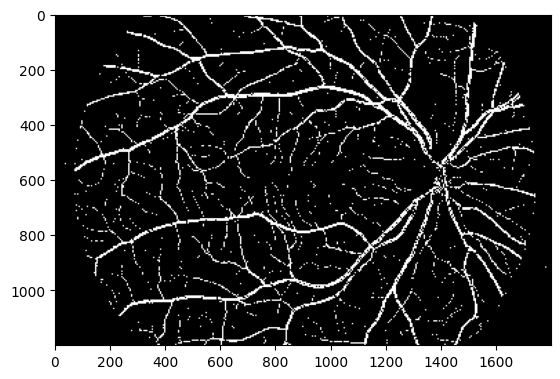

Accuracy 1:	 94.26
Recall 1:	 62.87
Specificity 1:	 98.30
Confusion matrix 1:	 [ 154804   32596   91429 1881171]



Zdjecie №2


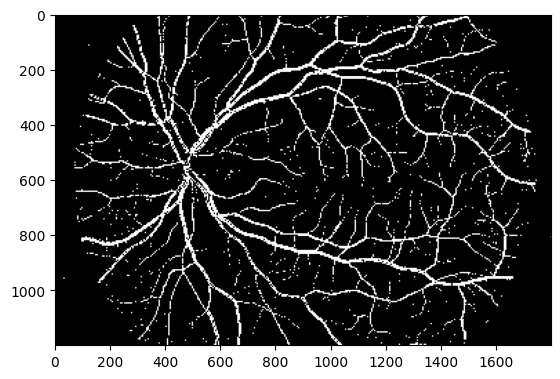

Accuracy 2:	 94.86
Recall 2:	 69.72
Specificity 2:	 97.95
Confusion matrix 2:	 [ 165074   39401   71681 1883844]



Zdjecie №3


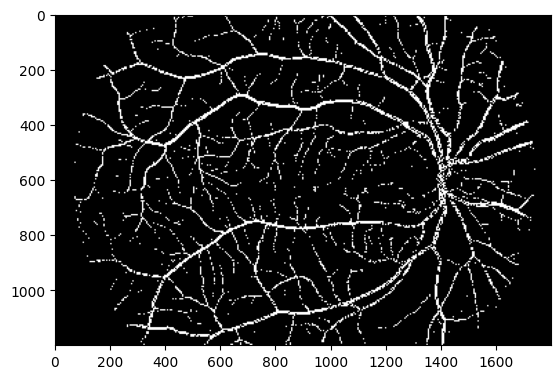

Accuracy 3:	 93.78
Recall 3:	 57.91
Specificity 3:	 98.51
Confusion matrix 3:	 [ 145854   28346  105989 1879811]



Zdjecie №4


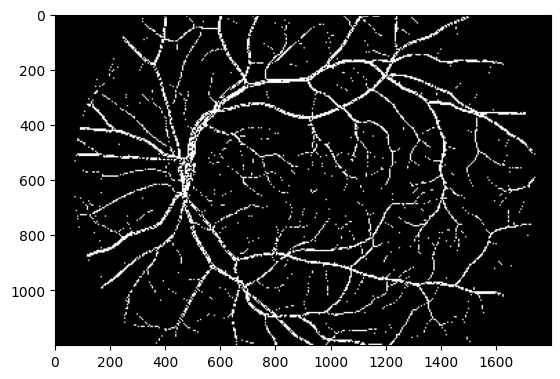

Accuracy 4:	 94.63
Recall 4:	 60.46
Specificity 4:	 98.64
Confusion matrix 4:	 [ 136942   26333   89575 1907150]



Zdjecie №5


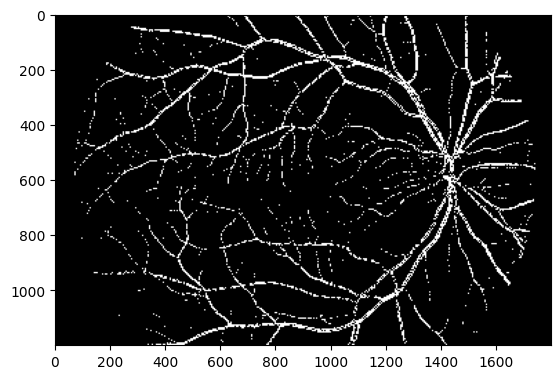

Accuracy 5:	 94.51
Recall 5:	 56.97
Specificity 5:	 98.70
Confusion matrix 5:	 [ 123635   25315   93374 1917676]



Zdjecie №6


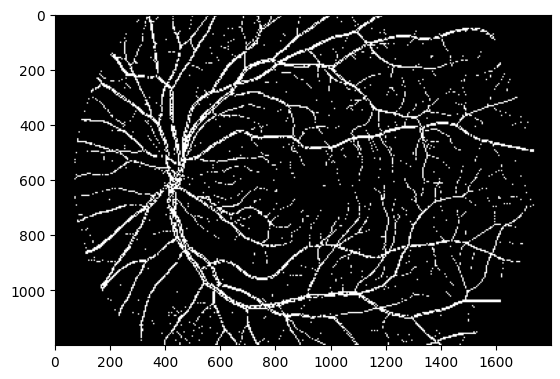

Accuracy 6:	 94.01
Recall 6:	 64.12
Specificity 6:	 97.86
Confusion matrix 6:	 [ 157799   40976   88307 1872918]



Zdjecie №7


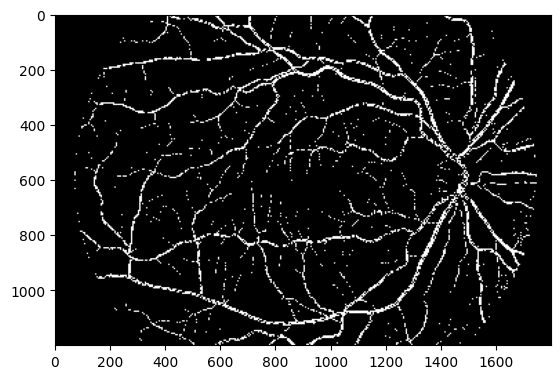

Accuracy 7:	 94.46
Recall 7:	 57.14
Specificity 7:	 98.58
Confusion matrix 7:	 [ 122672   27603   92018 1917707]



Zdjecie №8


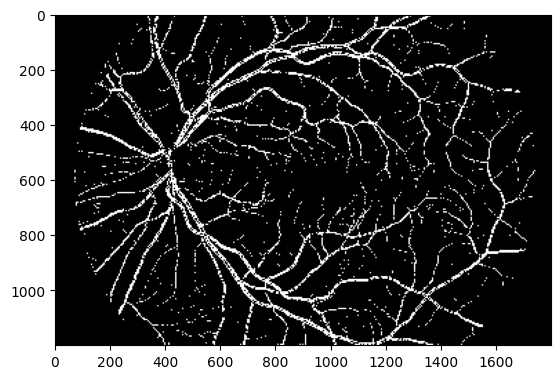

Accuracy 8:	 94.05
Recall 8:	 61.29
Specificity 8:	 98.19
Confusion matrix 8:	 [ 148439   34686   93771 1883104]



Zdjecie №9


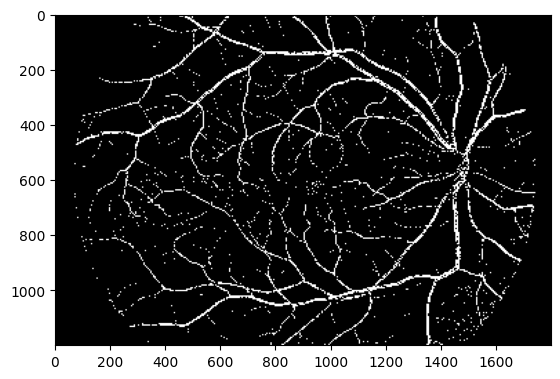

Accuracy 9:	 94.86
Recall 9:	 58.23
Specificity 9:	 98.41
Confusion matrix 9:	 [ 111102   31373   79688 1937837]


In [83]:
classifier = joblib.load('model.bin')
scaler = joblib.load('scaler.bin')

for img_num in range(1, 10):
    img_path = f'img/0{img_num}_h.jpg'
    mask_path = f'img/0{img_num}_h_mask.tif'
    expected_mask_path = f'img/0{img_num}_h.tif'

    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path)
    expected__mask = cv2.imread(expected_mask_path)

    resized_img = cv2.resize(copy.deepcopy(image), (1800, 1200))

    # Wyodrębnianie zielonego kanału i zwiększanie kontrastu
    green_img = resized_img[:, :, 1]
    green_mask = mask[:, :, 1]
    expected__mask = expected__mask[:, :, 1]

    expected__mask = cv2.resize(expected__mask, (1800, 1200))
    image_contrasted = cv2.equalizeHist(green_img)

    fragments = make_fragments(image_contrasted)

    # Wyodrębnianie cech z fragmentów
    array_image = []
    for fragment in fragments:
        flatten_array = fragment.flatten().astype(float)
        evidence = get_evidence(flatten_array)
        array_image.append(list(flatten_array) + evidence)

    x_test_transformed = scaler.transform(array_image)

    machine_image = classifier.predict(x_test_transformed)

    height, width, channels = resized_img.shape
    new_image = np.zeros((height, width))

    for x in range(0, height, 5):
        for y in range(0, width, 5):
            new_image[x:x+5, y:y+5] = machine_image[0]
            machine_image = machine_image[1:]

    normalized_image = (new_image / np.max(new_image)) * 255

    pil_image = Image.fromarray(normalized_image)
  #  pil_image = pil_image.convert('L')
    
    
    print(f'\n\n\nZdjecie №{img_num}')

    plt.imshow(normalized_image, cmap='gray')
    plt.show()

    metric = check_metrics(normalized_image, expected__mask)
    print(f"Accuracy {img_num}:\t {metric['accuracy'] * 100:.2f}")
    print(f"Recall {img_num}:\t {metric['recall'] * 100:.2f}")
    print(f"Specificity {img_num}:\t {metric['specificity'] * 100:.2f}")
    print(f"Confusion matrix {img_num}:\t {metric['confusion_matrix']}")